In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [2]:
#pd.set_option('display.max_rows', None)
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [3]:
import os;
os.chdir(r"C:\Users\user\Desktop\fdf")
fci_df = pd.read_csv("fulfilment_center_info.csv")
mi_df = pd.read_csv("meal_info.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("food_Demand_test.csv")

In [4]:
# head of fulfilment_center_info file
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [5]:
print("Shape of fulfilment_center_info :", fci_df.shape)

Shape of fulfilment_center_info : (77, 5)


In [6]:
# NaN values in fulfilment_center_info
fci_df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [7]:
# head of meal_info file
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [8]:
print("Shape of meal_info: ", mi_df.shape)

Shape of meal_info:  (51, 3)


In [9]:
mi_df.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [10]:
# Head of Train file (historical demand data)
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1000000,3,157,2760,233.83,231.83,0,0,149
1,1000001,100,104,2956,486.03,583.03,0,0,161
2,1000002,143,75,1971,328.86,327.86,0,0,149
3,1000003,41,24,2539,145.53,145.53,0,0,540
4,1000004,45,83,2539,95.06,120.34,0,0,271


In [11]:
print("Shape of train: ", train_df.shape)

Shape of train:  (1999, 9)


In [12]:
# NaN values in train data
train_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [13]:
# Head of Test data
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [14]:
print("Shape of Test: ", test_df.shape)

Shape of Test:  (32573, 8)


In [15]:
# NaN values in test data
test_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

EDA
FULFILLMENT CENTER INFO

In [16]:
print("Total number of centers : ", fci_df['center_id'].nunique())


Total number of centers :  77


In [17]:
print("Types of centers : \n")
print(fci_df['center_type'].unique())

Types of centers : 

['TYPE_A' 'TYPE_B' 'TYPE_C']


In [18]:
ax = sns.countplot(fci_df['center_type'])
ax.set(ylabel='Number of centers')
plt.show()

ValueError: could not convert string to float: 'TYPE_A'

In [19]:
print("Total Number of cities: ", fci_df['city_code'].nunique())


Total Number of cities:  51


In [20]:
print("Total number of regions: ", fci_df['region_code'].nunique())


Total number of regions:  8


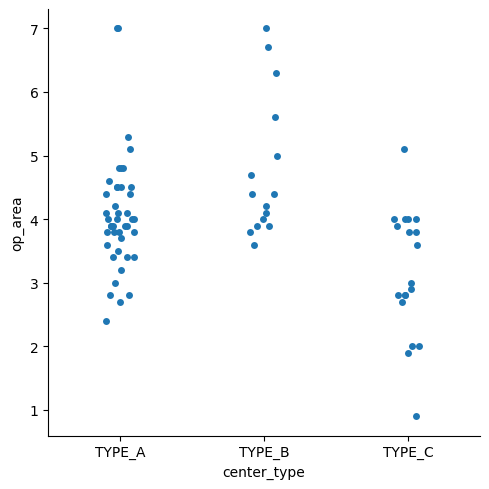

In [21]:
sns.catplot(x = 'center_type', y = 'op_area', data=fci_df)
plt.show()

In [22]:
fci_df['region_code'] = fci_df['city_code'].astype(str) + "_" + fci_df['region_code'].astype(str)
fci_df['region_code'].nunique()

51

so in the one city there is not any centers which are in different regions. so maybe region code will not be helpful.

In [23]:
fci_df.drop('region_code', axis=1, inplace=True)


FOOD_ITEM_INFO

In [24]:
print("Total number of different types of meal: ", mi_df['meal_id'].nunique())


Total number of different types of meal:  51


In [25]:
ax = sns.countplot(mi_df['category'])
ax.set(ylabel= "Number of Meals")
plt.xticks(rotation=80)
plt.show()

ValueError: could not convert string to float: 'Beverages'

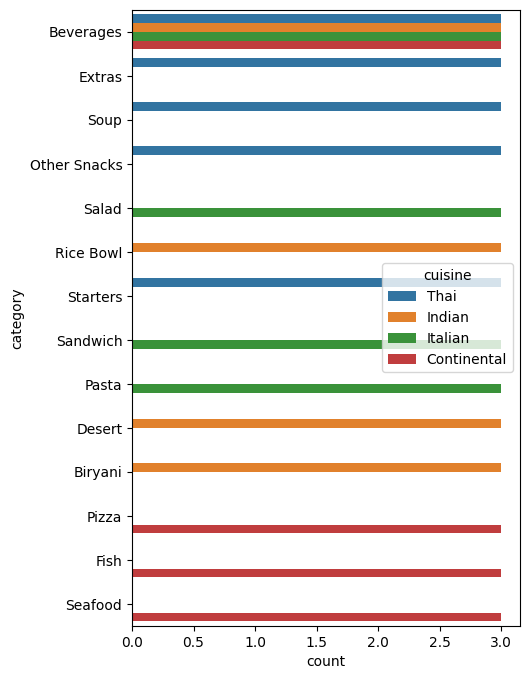

In [26]:
fig, ax = plt.subplots(figsize=(5,8))
sns.countplot(y = mi_df['category'], hue=mi_df['cuisine'], ax=ax)
plt.show()

In [27]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [28]:
train_df.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine
0,1000000,3,157,2760,233.83,231.83,0,0,149,609,TYPE_A,4.1,Other Snacks,Thai
1,1001086,144,157,2760,184.36,261.93,0,0,96,609,TYPE_A,4.1,Other Snacks,Thai
2,1001863,120,157,2760,219.28,241.53,0,0,27,609,TYPE_A,4.1,Other Snacks,Thai
3,1000867,38,24,2760,242.53,242.53,0,0,204,614,TYPE_B,3.6,Other Snacks,Thai
4,1001080,131,83,2760,260.93,260.93,0,0,107,659,TYPE_A,5.3,Other Snacks,Thai


In [29]:
c_m_tr = (train_df['center_id'].astype(str) + "_" + train_df['meal_id'].astype(str)).unique()
print("there are ", len(c_m_tr), " center-meal pairs in train data")

there are  1534  center-meal pairs in train data


In [30]:
c_m_te = (test_df['center_id'].astype(str) + "_" + test_df['meal_id'].astype(str)).unique()
print("there are ", len(c_m_te), " center-meal pairs in test data")

there are  3548  center-meal pairs in test data


In [31]:
# check if test set has any new center-mean pair or not
print("There are ", len(set(c_m_te) - set(c_m_tr)), " new center-meal pairs in test dataset which are not present in train dataset")
print(set(c_m_te) - set(c_m_tr))

There are  2021  new center-meal pairs in test dataset which are not present in train dataset
{'149_1207', '101_2492', '110_2304', '153_1445', '92_2581', '108_1571', '124_1803', '145_1993', '41_2304', '174_2664', '174_2492', '109_2539', '186_2139', '17_2826', '157_2444', '34_2577', '104_2760', '26_2492', '86_2640', '51_2577', '94_2581', '129_1062', '50_2577', '86_2581', '102_1525', '11_1216', '17_1847', '146_1558', '104_2494', '17_2577', '153_1993', '153_2290', '67_2539', '157_2640', '52_1993', '68_2490', '99_2139', '14_1727', '152_2126', '53_1525', '94_1445', '149_1558', '132_2581', '108_1247', '17_1803', '50_2867', '10_2490', '161_1230', '75_1558', '146_1445', '66_1571', '94_1727', '143_1247', '81_1445', '58_1062', '161_2490', '10_2304', '162_1885', '99_2760', '109_1971', '32_1885', '52_2577', '29_2956', '102_1971', '137_2631', '55_1230', '186_1902', '161_1216', '36_2492', '126_1525', '104_1230', '72_2126', '76_1525', '126_1770', '101_1558', '145_2664', '13_2104', '72_1216', '53_1778

In [32]:
test_df[(test_df['center_id']==73) & (test_df['meal_id'].isin([2956, 1571]))].shape[0]


11

In [33]:
test_df[(test_df['center_id']==92) & (test_df['meal_id'].isin([2104]))].shape[0]


2

There should be 77*51 = 3927 center-meal pair, but we have 3597 pairs in train data, that means some centers did not sell some of the meals.

There should be 3597*145 = 521565 records in past 145 week data, but we have 456548 records. which means some centers did not sell some meal for some week or they stared selling some new type of meal after some weeks. Same with test data.

Test set has only 3548 center-meal pair, that means some of the centers did not sell some type of meals in this 10 week.

Here in the test set (future 10 week), center 73 started selling meal 2956 & 1571, center 92 started selling meal 2104, which they have never sold in last 145 weeks. There are only 13 records with unknown center-meal pair in test set.

In [34]:
train_df['b_c_p_diff'] = train_df['base_price'] - train_df['checkout_price']


In [35]:
test_df['b_c_p_diff'] = test_df['base_price'] - test_df['checkout_price']


Catboost model1 : LB : 158

In [36]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,center_type,op_area,category,cuisine,b_c_p_diff
0,1028232,146,55,1885,158.11,159.11,0,0,647,TYPE_C,2.0,Beverages,Thai,1.0
1,1262649,147,55,1885,159.11,159.11,0,0,647,TYPE_C,2.0,Beverages,Thai,0.0
2,1453211,149,55,1885,157.14,158.14,0,0,647,TYPE_C,2.0,Beverages,Thai,1.0
3,1262599,150,55,1885,159.14,157.14,0,0,647,TYPE_C,2.0,Beverages,Thai,-2.0
4,1495848,151,55,1885,160.11,159.11,0,0,647,TYPE_C,2.0,Beverages,Thai,-1.0


In [37]:
features0 = [col for col in test_df.columns if col not in ['id']]


In [38]:
features0


['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'b_c_p_diff']

In [39]:
cat_ind0 = [1, 2, 5, 6, 7, 8, 10, 11]
cat_re0 = cb.CatBoostRegressor(random_seed=2018)


In [40]:
cat_re0.fit(train_df[features0], train_df['num_orders'], cat_features=cat_ind0, verbose=False, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
100 * np.sqrt(mean_squared_log_error(np.clip(cat_re0.predict(train_df[features0]), 0, 10000), train_df['num_orders']))


In [41]:
sub_df = pd.read_csv("sample_submission.csv")

sub_df['num_orders'] = np.clip(cat_re0.predict(test_df[features0]), 0, 10000)
sub_df.to_csv('cat0.csv', index=False)

ValueError: Length of values (32573) does not match length of index (57537505)

In [42]:
sns.barplot(cat_re0.feature_importances_, features0)
plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

In [43]:
print("params : ", cat_re0.get_params())
print("Learning rate: ", cat_re0.learning_rate_)
print("tree counts: ", cat_re0.tree_count_)

params :  {'loss_function': 'RMSE', 'random_seed': 2018}
Learning rate:  0.04567800089716911
tree counts:  1000


Further analysis on entire data and feature engineering


In [44]:
all_df = train_df.append(test_df, sort=True).reset_index(drop=True)
all_df = all_df[train_df.columns]

C:\Users\user\AppData\Local\Temp\ipykernel_11756\4027647948.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = train_df.append(test_df, sort=True).reset_index(drop=True)


In [45]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)


In [46]:
all_df['last_pre_cp_diff'] = all_df['checkout_price'].shift(1) - all_df['checkout_price']


In [47]:
all_df.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff
0,1001946,50,10,1062,180.45,179.45,0,0,404.0,590,TYPE_B,6.3,Beverages,Italian,-1.00,NaN
1,1001332,61,10,1062,161.05,183.39,0,0,1270.0,590,TYPE_B,6.3,Beverages,Italian,22.34,19.40
2,1177098,146,10,1062,190.18,190.18,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,0.00,-29.13
3,1486011,147,10,1062,193.03,194.03,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,1.00,-2.85
4,1301735,148,10,1062,191.09,191.09,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,0.00,1.94


In [48]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
        all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'last_pre_cp_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['last_pre_cp_diff'].mean()


In [49]:
all_df['price_increase'] = all_df['last_pre_cp_diff'] < 0


In [50]:
all_df['high_price_che_than_base'] = all_df['b_c_p_diff'] < 0


In [51]:
all_df.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
0,1001946,50,10,1062,180.45,179.45,0,0,404.0,590,TYPE_B,6.3,Beverages,Italian,-1.00,1.678182,False,True
1,1001332,61,10,1062,161.05,183.39,0,0,1270.0,590,TYPE_B,6.3,Beverages,Italian,22.34,19.400000,False,False
2,1177098,146,10,1062,190.18,190.18,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,0.00,-29.130000,True,False
3,1486011,147,10,1062,193.03,194.03,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,1.00,-2.850000,True,False
4,1301735,148,10,1062,191.09,191.09,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,0.00,1.940000,False,False


In [52]:
all_df[all_df['last_pre_cp_diff'].isnull()]


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
7687,1000319,7,41,1803,161.05,183.36,0,0,26.0,590,TYPE_C,1.9,Extras,Thai,22.31,NaN,False,False
7709,1247248,148,41,1902,446.23,446.23,0,0,NaN,590,TYPE_C,1.9,Biryani,Indian,0.00,NaN,False,False
7799,1001793,95,41,2492,388.03,388.03,0,0,40.0,590,TYPE_C,1.9,Desert,Indian,0.00,NaN,False,False
11051,1492097,155,55,1902,445.23,445.23,0,0,NaN,647,TYPE_C,2.0,Biryani,Indian,0.00,NaN,False,False
11366,1052283,149,57,1770,425.83,484.03,0,0,NaN,541,TYPE_C,2.8,Biryani,Indian,58.20,NaN,False,False
15747,1416956,149,72,2956,582.03,583.03,0,0,NaN,638,TYPE_C,3.9,Fish,Continental,1.00,NaN,False,False
16213,1372749,155,74,1247,445.23,445.23,0,0,NaN,702,TYPE_A,2.8,Biryani,Indian,0.00,NaN,False,False
20930,1000633,73,91,2704,244.50,291.03,0,0,14.0,590,TYPE_C,0.9,Other Snacks,Thai,46.53,NaN,False,False
21016,1095570,151,92,1525,262.93,319.13,0,0,NaN,526,TYPE_C,2.9,Other Snacks,Thai,56.20,NaN,False,False
21841,1001773,112,94,1571,581.03,582.03,0,0,14.0,632,TYPE_C,3.6,Fish,Continental,1.00,NaN,False,False


In [61]:
show_all(all_df[21000:21300], 0, 0)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
21000,1325619,155,92,1247,446.23,445.23,0,0,NaN,526,TYPE_C,2.9,Biryani,Indian,-1.00,1.000000,False,True
21001,1000996,80,92,1248,97.00,153.26,0,0,81.0,526,TYPE_C,2.9,Beverages,Indian,56.26,-5.114545,True,False
21002,1000644,85,92,1248,94.15,149.38,1,1,310.0,526,TYPE_C,2.9,Beverages,Indian,55.23,2.850000,False,False
21003,1276615,146,92,1248,131.01,148.41,0,0,NaN,526,TYPE_C,2.9,Beverages,Indian,17.40,-36.860000,True,False
21004,1191397,147,92,1248,93.12,148.41,0,0,NaN,526,TYPE_C,2.9,Beverages,Indian,55.29,37.890000,False,False
21005,1257720,148,92,1248,97.06,148.41,0,0,NaN,526,TYPE_C,2.9,Beverages,Indian,51.35,-3.940000,True,False
21006,1217814,149,92,1248,93.12,149.41,0,0,NaN,526,TYPE_C,2.9,Beverages,Indian,56.29,3.940000,False,False
21007,1169274,150,92,1248,92.15,148.41,0,0,NaN,526,TYPE_C,2.9,Beverages,Indian,56.26,0.970000,False,False
21008,1447542,151,92,1248,97.00,150.41,0,0,NaN,526,TYPE_C,2.9,Beverages,Indian,53.41,-4.850000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Here we have some center-meal pair which has only occurred once, that's why we have NaN value for last_pre_cp_diff column for these 3 records. Let's put 0 for this.

In [62]:
all_df['last_pre_cp_diff'] = all_df['last_pre_cp_diff'].fillna(0)


C:\Users\user\AppData\Local\Temp\ipykernel_11756\1172522682.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_df['num_orders'].dropna(), bins=500)


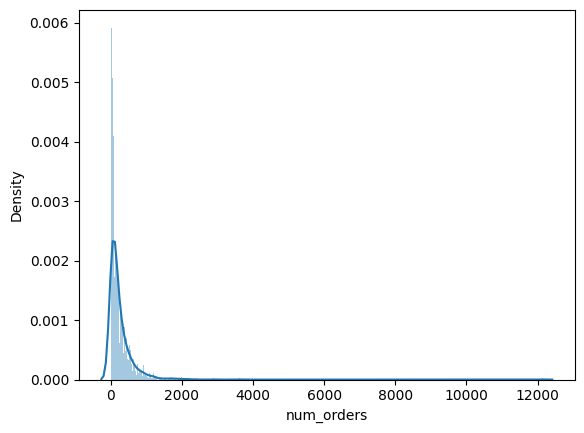

In [63]:
sns.distplot(all_df['num_orders'].dropna(), bins=500)
plt.show()

Target variable is highly skewd, so it's better if we use log of it for prediction.

C:\Users\user\AppData\Local\Temp\ipykernel_11756\3437172169.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(all_df['num_orders'].dropna()), bins=500)


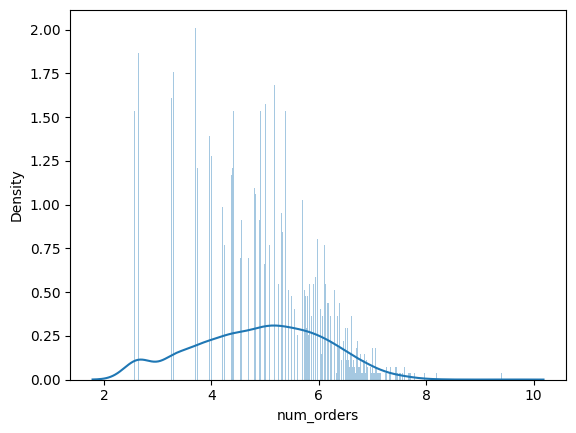

In [64]:
sns.distplot(np.log(all_df['num_orders'].dropna()), bins=500)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11756\3934017950.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(all_df['checkout_price']), bins=500)


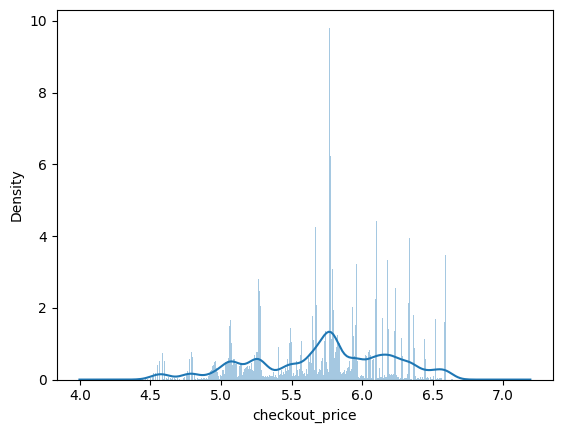

In [65]:
sns.distplot(np.log(all_df['checkout_price']), bins=500)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11756\133536745.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_df['base_price'], bins=500)


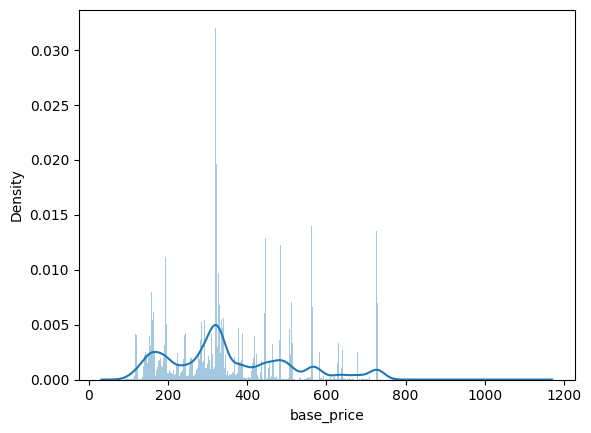

In [66]:

sns.distplot(all_df['base_price'], bins=500)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11756\545390485.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(all_df['base_price']), bins=500)


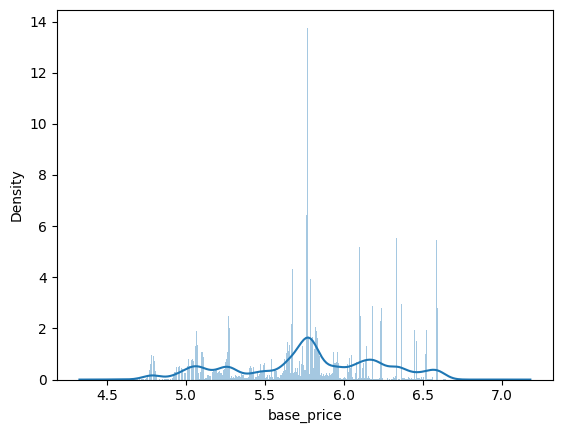

In [67]:

sns.distplot(np.log(all_df['base_price']), bins=500)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11756\2942575265.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_df['last_pre_cp_diff'], bins=500)


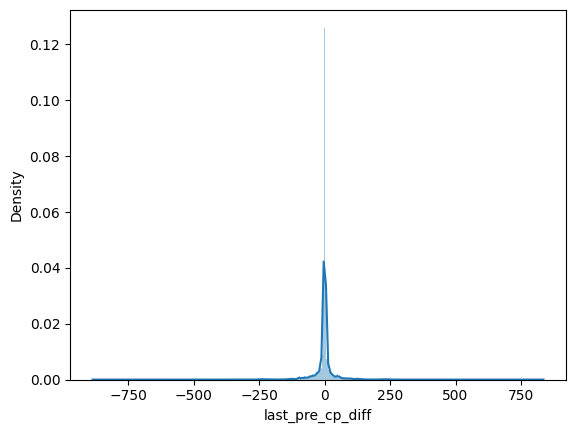

In [68]:
sns.distplot(all_df['last_pre_cp_diff'], bins=500)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11756\2395805642.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_df['b_c_p_diff'], bins=500)


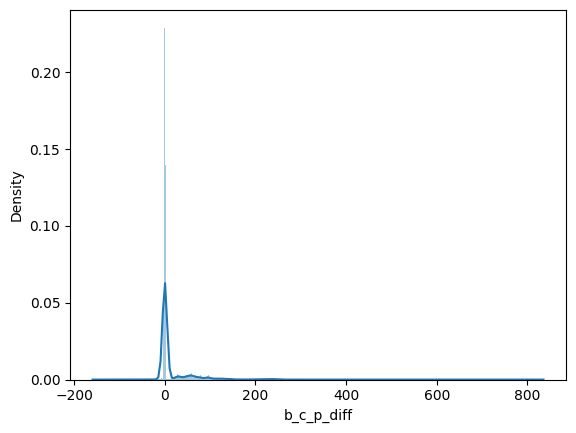

In [69]:
sns.distplot(all_df['b_c_p_diff'], bins=500)
plt.show()

In [72]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)


In [74]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
        all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()

    


In [75]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)



Time based cross validation:

Here we take last 10 weeks from train set as a validation data.



In [77]:
all_df.loc[all_df['week'].isin(np.arange(136,146)), 'train_or_test'] = 'val'


In [78]:
all_df.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base,price_last_curr_diff,train_or_test
0,1001946,50,10,1062,180.45,179.45,0,0,404.0,590,TYPE_B,6.3,Beverages,Italian,-1.00,1.678182,0,True,0.006601,NaN
1,1001332,61,10,1062,161.05,183.39,0,0,1270.0,590,TYPE_B,6.3,Beverages,Italian,22.34,19.400000,0,False,0.107509,NaN
2,1177098,146,10,1062,190.18,190.18,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,0.00,-29.130000,1,False,-0.180876,NaN
3,1486011,147,10,1062,193.03,194.03,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,1.00,-2.850000,1,False,-0.014986,NaN
4,1301735,148,10,1062,191.09,191.09,0,0,NaN,590,TYPE_B,6.3,Beverages,Italian,0.00,1.940000,0,False,0.010050,NaN


In [79]:
trn_df = all_df.loc[all_df.train_or_test.isin(['train','val']), :]


In [80]:
Y_val = trn_df.loc[trn_df.train_or_test=='val', 'num_orders'].values.reshape((-1))
Y_train = trn_df.loc[trn_df.train_or_test=='train', 'num_orders'].values.reshape((-1))
trn_df.loc[trn_df.train_or_test=='val', 'num_orders'] = np.nan


In [81]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [82]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [83]:
def one_hot_encoder(df, ohe_cols):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [84]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
trn_df = create_sales_lag_feats(trn_df, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11,12,13,14,15,26,27,28,29])

trn_df = create_sales_rmean_feats(trn_df, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type='triang')

trn_df = create_sales_rmed_feats(trn_df, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type=None)

trn_df = create_sales_ewm_feats(trn_df, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[10,11,12,13,14,15,26,27,28,29])

C:\Users\user\AppData\Local\Temp\ipykernel_11756\2981220667.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_'.join([target_col, 'lag', str(i)])] = \
C:\Users\user\AppData\Local\Temp\ipykernel_11756\2981220667.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_'.join([target_col, 'lag', str(i)])] = \
C:\Users\user\AppData\Local\Temp\ipykernel_11756\2981220667.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [85]:
trn_df.shape


(148, 96)

In [86]:
show_all(trn_df, 5, None)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base,price_last_curr_diff,train_or_test,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_13,num_orders_lag_14,num_orders_lag_15,num_orders_lag_26,num_orders_lag_27,num_orders_lag_28,num_orders_lag_29,num_orders_rmean_26,num_orders_rmean_52,num_orders_rmean_104,num_orders_rmed_26,num_orders_rmed_52,num_orders_rmed_104,num_orders_lag_10_ewm_0.95,num_orders_lag_11_ewm_0.95,num_orders_lag_12_ewm_0.95,num_orders_lag_13_ewm_0.95,num_orders_lag_14_ewm_0.95,num_orders_lag_15_ewm_0.95,num_orders_lag_26_ewm_0.95,num_orders_lag_27_ewm_0.95,num_orders_lag_28_ewm_0.95,num_orders_lag_29_ewm_0.95,num_orders_lag_10_ewm_0.9,num_orders_lag_11_ewm_0.9,num_orders_lag_12_ewm_0.9,num_orders_lag_13_ewm_0.9,num_orders_lag_14_ewm_0.9,num_orders_lag_15_ewm_0.9,num_orders_lag_26_ewm_0.9,num_orders_lag_27_ewm_0.9,num_orders_lag_28_ewm_0.9,num_orders_lag_29_ewm_0.9,num_orders_lag_10_ewm_0.8,num_orders_lag_11_ewm_0.8,num_orders_lag_12_ewm_0.8,num_orders_lag_13_ewm_0.8,num_orders_lag_14_ewm_0.8,num_orders_lag_15_ewm_0.8,num_orders_lag_26_ewm_0.8,num_orders_lag_27_ewm_0.8,num_orders_lag_28_ewm_0.8,num_orders_lag_29_ewm_0.8,num_orders_lag_10_ewm_0.7,num_orders_lag_11_ewm_0.7,num_orders_lag_12_ewm_0.7,num_orders_lag_13_ewm_0.7,num_orders_lag_14_ewm_0.7,num_orders_lag_15_ewm_0.7,num_orders_lag_26_ewm_0.7,num_orders_lag_27_ewm_0.7,num_orders_lag_28_ewm_0.7,num_orders_lag_29_ewm_0.7,num_orders_lag_10_ewm_0.6,num_orders_lag_11_ewm_0.6,num_orders_lag_12_ewm_0.6,num_orders_lag_13_ewm_0.6,num_orders_lag_14_ewm_0.6,num_orders_lag_15_ewm_0.6,num_orders_lag_26_ewm_0.6,num_orders_lag_27_ewm_0.6,num_orders_lag_28_ewm_0.6,num_orders_lag_29_ewm_0.6,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5,num_orders_lag_26_ewm_0.5,num_orders_lag_27_ewm_0.5,num_orders_lag_28_ewm_0.5,num_orders_lag_29_ewm_0.5
232,1000148,143,10,1885,151.38,149.38,0,0,NaN,590,TYPE_B,6.3,Beverages,Thai,-2.0,-0.679000,1,True,-0.004469,val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,1001854,139,10,2640,320.13,321.13,0,0,NaN,590,TYPE_B,6.3,Starters,Thai,1.0,0.100000,0,False,0.000109,val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34488,1001909,136,186,2631,95.06,154.26,0,1,NaN,649,TYPE_A,3.4,Beverages,Indian,59.2,-6.020000,1,False,-0.071089,val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34521,1002132,142,186,2704,319.13,319.13,0,0,NaN,649,TYPE_A,3.4,Other Snacks,Thai,0.0,-0.222222,1,False,-0.004426,val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [88]:
X_trn = trn_df.loc[trn_df['train_or_test']=='train', :]
X_val = trn_df.loc[trn_df['train_or_test']=='val', :]


In [89]:
X_trn.shape


(0, 96)

In [90]:
X_val.shape

(148, 96)

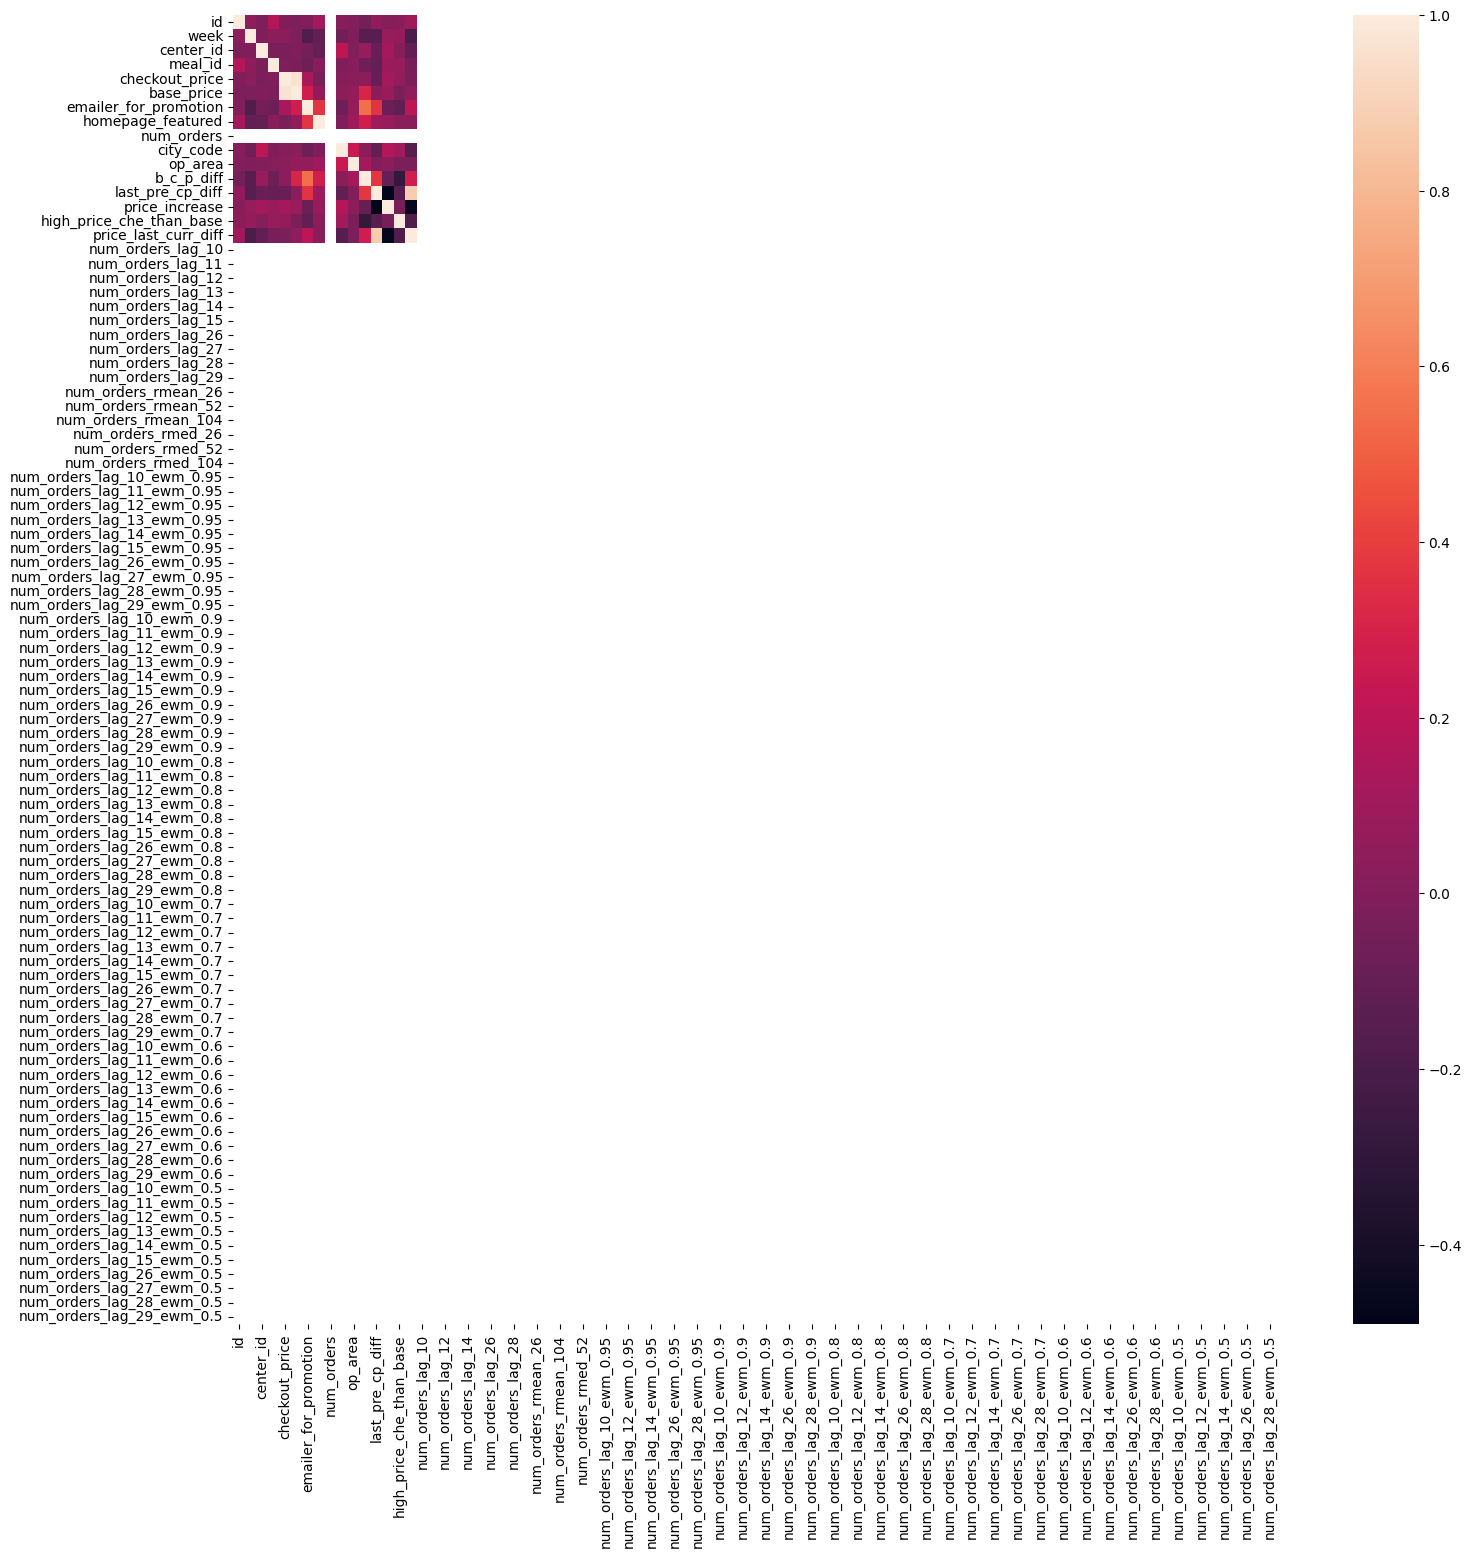

In [91]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(trn_df.corr(), ax=ax)
plt.show()